In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import phik
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.ensemble import *
from imblearn.over_sampling import *
from sklearn.naive_bayes import *
from sklearn.tree import *

In [12]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.drop(columns=['id', 'Surname'])

In [26]:
# Ensure the balance and estimated salary are rounded before applying WoE or plotting histograms
train_df['Balance'] = train_df['Balance'].apply(lambda x: round(x))
train_df['EstimatedSalary'] = train_df['EstimatedSalary'].apply(lambda x: round(x))

test_df['Balance'] = test_df['Balance'].apply(lambda x: round(x))
test_df['EstimatedSalary'] = test_df['EstimatedSalary'].apply(lambda x: round(x))

# WoE function remains the same
def get_WoE(data, feature_name, target_name, sort=False):
    df = data.copy()
    df = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    df['Percentage events'] = df['# of events'] / df['# of events'].sum()
    df['Percentage non-events'] = df['# of non-events'] / df['# of non-events'].sum()
    df['WOE'] = np.log(df['Percentage events'] / df['Percentage non-events'])

    df['Total Observations'] = df['# of events'] + df['# of non-events']
    df['Percent of Observations'] = (df['Total Observations'] / \
                                            df['Total Observations'].sum() * 100).round(3)
    df['rank'] = df['WOE'].rank()
    if sort:
        df = df.sort_values('WOE')
    return df.reset_index()

# Histogram plotting with rounded Balance and EstimatedSalary
def plot_histograms(train_df, test_df, cat, rank, rotation=40):
    # Make sure to round Balance and EstimatedSalary before plotting
    train_df['Balance'] = train_df['Balance'].apply(lambda x: round(x))
    train_df['EstimatedSalary'] = train_df['EstimatedSalary'].apply(lambda x: round(x))

    test_df['Balance'] = test_df['Balance'].apply(lambda x: round(x))
    test_df['EstimatedSalary'] = test_df['EstimatedSalary'].apply(lambda x: round(x))

    fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    sns.histplot(data=train_df[rank].astype(str), kde=True, ax=ax[0][0])
    ax[0][0].set_title(f'{rank} in Train')
    sns.histplot(data=train_df[cat].astype(str), kde=True, ax=ax[0][1])
    ax[0][1].set_title(f'{cat} in Train')

    sns.histplot(data=test_df[rank].astype(str), kde=True, ax=ax[1][0])
    ax[1][0].set_title(f'{rank} in Test')
    sns.histplot(data=test_df[cat].astype(str), kde=True, ax=ax[1][1])
    ax[1][1].set_title(f'{cat} in Test')

    for axes in ax.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=rotation)

    plt.tight_layout()
    plt.show()


EstimatedSalary: Correlation = 0.019, p-value = 0.0
EstimatedSalary_log: Correlation = 0.013, p-value = 0.0
EstimatedSalary_scaled: Correlation = 0.019, p-value = 0.0
Age_x_EstimatedSalary: Correlation = 0.176, p-value = 0.0


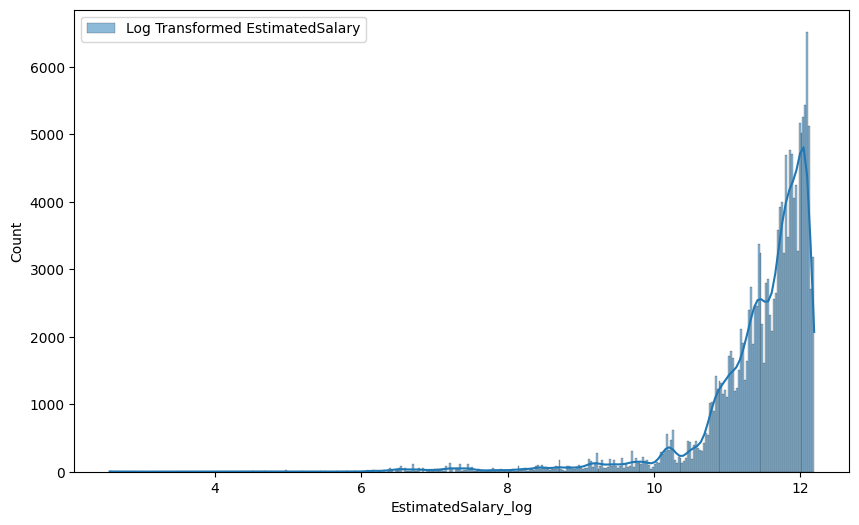

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Binning/Grouping EstimatedSalary
def create_salary_bins(df, column='EstimatedSalary', bins=5):
    labels = [f"Bin_{i}" for i in range(1, bins+1)]
    df[f'{column}_binned'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

# 2. Applying transformations (log transformation)
def apply_log_transformation(df, column='EstimatedSalary'):
    df[f'{column}_log'] = np.log1p(df[column])  # log1p to handle zero values
    return df

# 3. Interaction Term
def create_interaction_term(df, col1, col2):
    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
    return df

# 4. Handling outliers (capping outliers at 99th percentile)
def handle_outliers(df, column):
    upper_limit = df[column].quantile(0.99)
    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    return df

# 5. Feature Scaling (Standardization)
from sklearn.preprocessing import StandardScaler

def scale_feature(df, column):
    scaler = StandardScaler()
    df[f'{column}_scaled'] = scaler.fit_transform(df[[column]])
    return df

# Function to calculate Point-Biserial Correlation
def calculate_point_biserial(df, target='Exited', feature_list=None):
    if feature_list is None:
        feature_list = ['Age', 'CreditScore', 'EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure']
    
    correlation_results = {}
    for feature in feature_list:
        # Ensure that the feature is numeric
        if pd.api.types.is_numeric_dtype(df[feature]):
            ps_corr, p_value = stats.pointbiserialr(df[target], df[feature])
            correlation_results[feature] = (round(ps_corr, 3), round(p_value, 3))
        else:
            print(f"Skipping non-numeric feature: {feature}")
    
    return correlation_results

# Load data (assuming train_df_cleaned is pre-loaded and cleaned)
train_df_cleaned = handle_outliers(train_df, 'EstimatedSalary')  # Handle outliers
train_df_cleaned = create_salary_bins(train_df_cleaned, bins=5)  # Create bins for EstimatedSalary
train_df_cleaned = apply_log_transformation(train_df_cleaned)  # Log transformation
train_df_cleaned = create_interaction_term(train_df_cleaned, 'Age', 'EstimatedSalary')  # Interaction term
train_df_cleaned = scale_feature(train_df_cleaned, 'EstimatedSalary')  # Scale the feature

# Calculate point-biserial correlation after transformation
features_to_check = ['EstimatedSalary', 'EstimatedSalary_log', 'EstimatedSalary_scaled', 'Age_x_EstimatedSalary']
correlation_results = calculate_point_biserial(train_df_cleaned, feature_list=features_to_check)

# Print the results
for feature, (corr, p_value) in correlation_results.items():
    print(f"{feature}: Correlation = {corr}, p-value = {p_value}")

# Plot the distribution after transformation
plt.figure(figsize=(10, 6))
sns.histplot(train_df_cleaned['EstimatedSalary_log'], kde=True, label='Log Transformed EstimatedSalary')
plt.legend()
plt.show()


In [37]:
from scipy import stats
import numpy as np

# Create interaction term
train_df['Age_x_EstimatedSalary'] = train_df['Age'] * train_df['EstimatedSalary']

# Ensure all necessary columns are numeric and have no missing values
train_df = train_df.dropna(subset=['Age', 'CreditScore', 'EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'Age_x_EstimatedSalary', 'Exited'])

# Calculate Point-Biserial Correlation Coefficient and p-values
age_ps, age_p_value = stats.pointbiserialr(train_df['Exited'], train_df['Age'])
CreditScore_ps, CreditScore_p_value = stats.pointbiserialr(train_df['Exited'], train_df['CreditScore'])
EstimatedSalary_ps, EstimatedSalary_p_value = stats.pointbiserialr(train_df['Exited'], train_df['EstimatedSalary'])
Balance_ps, Balance_p_value = stats.pointbiserialr(train_df['Exited'], train_df['Balance'])
NumOfProducts_ps, NumOfProducts_p_value = stats.pointbiserialr(train_df['Exited'], train_df['NumOfProducts'])
Tenure_ps, Tenure_p_value = stats.pointbiserialr(train_df['Exited'], train_df['Tenure'])
Age_x_EstimatedSalary_ps, Age_x_EstimatedSalary_p_value = stats.pointbiserialr(train_df['Exited'], train_df['Age_x_EstimatedSalary'])

# Create the output text
text = f"""
Age: {round(age_ps, 3)} (p-value: {round(age_p_value, 3)})\n
CreditScore: {round(CreditScore_ps, 3)} (p-value: {round(CreditScore_p_value, 3)})\n
EstimatedSalary: {round(EstimatedSalary_ps, 3)} (p-value: {round(EstimatedSalary_p_value, 3)})\n
Balance: {round(Balance_ps, 3)} (p-value: {round(Balance_p_value, 3)})\n
NumOfProducts: {round(NumOfProducts_ps, 3)} (p-value: {round(NumOfProducts_p_value, 3)})\n
Tenure: {round(Tenure_ps, 3)} (p-value: {round(Tenure_p_value, 3)})\n
Age_x_EstimatedSalary: {round(Age_x_EstimatedSalary_ps, 3)} (p-value: {round(Age_x_EstimatedSalary_p_value, 3)})
"""

# Print the results
print(text)



Age: 0.341 (p-value: 0.0)

CreditScore: -0.027 (p-value: 0.0)

EstimatedSalary: 0.019 (p-value: 0.0)

Balance: 0.13 (p-value: 0.0)

NumOfProducts: -0.215 (p-value: 0.0)

Tenure: -0.02 (p-value: 0.0)

Age_x_EstimatedSalary: 0.176 (p-value: 0.0)



Chi-Squared Test Results:
              Feature  Chi-Squared Score   P-Value
0           HasCrCard          19.906630  0.000008
1      IsActiveMember        3663.484427  0.000000
2  HasCrCard_IsActive        3302.919850  0.000000
interval columns not set, guessing: ['HasCrCard', 'IsActiveMember', 'HasCrCard_IsActive', 'EstimatedSalary_binned', 'Age_binned', 'Exited']

Phi-K Correlation Matrix:
                        HasCrCard  IsActiveMember  HasCrCard_IsActive  \
HasCrCard                1.000000        0.032783            0.635596   
IsActiveMember           0.032783        1.000000            0.936016   
HasCrCard_IsActive       0.635596        0.936016            1.000000   
EstimatedSalary_binned   0.012428        0.017270            0.014362   
Age_binned               0.009843        0.068942            0.055139   
Exited                   0.034529        0.324228            0.276444   

                        EstimatedSalary_binned  Age_binned    Exited  
HasCrCard           

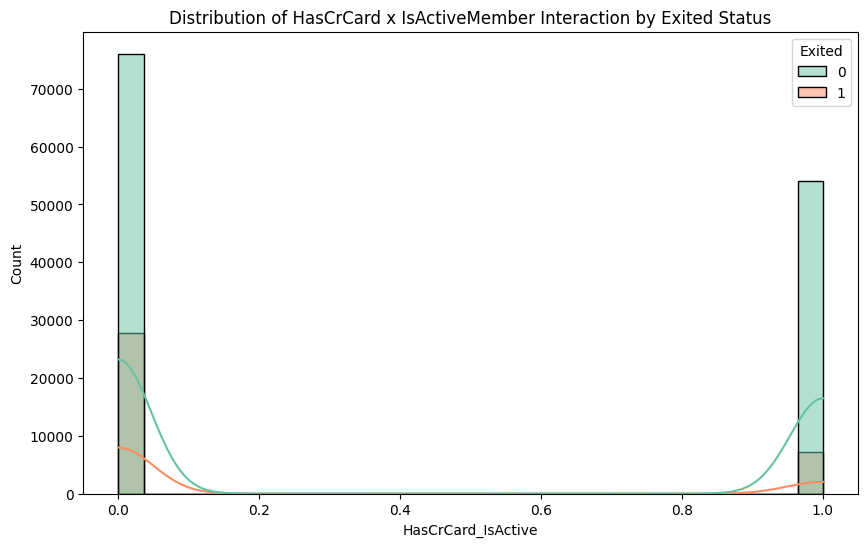

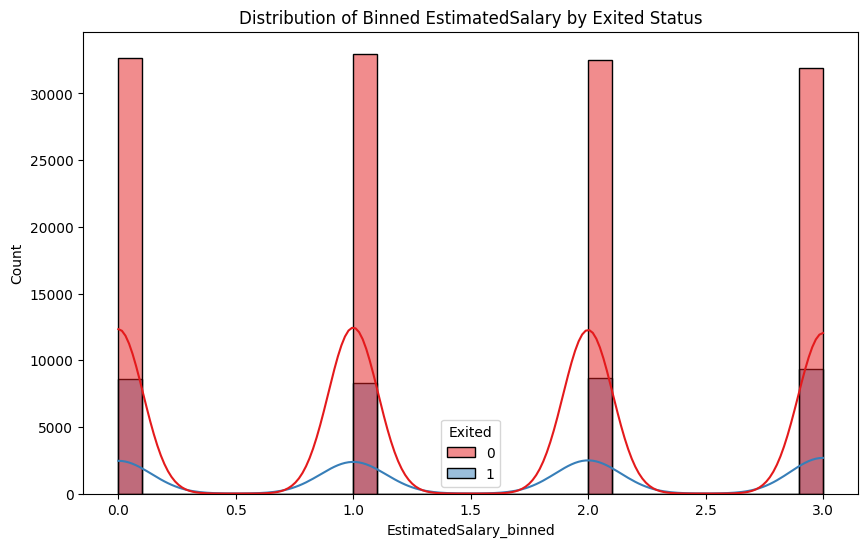

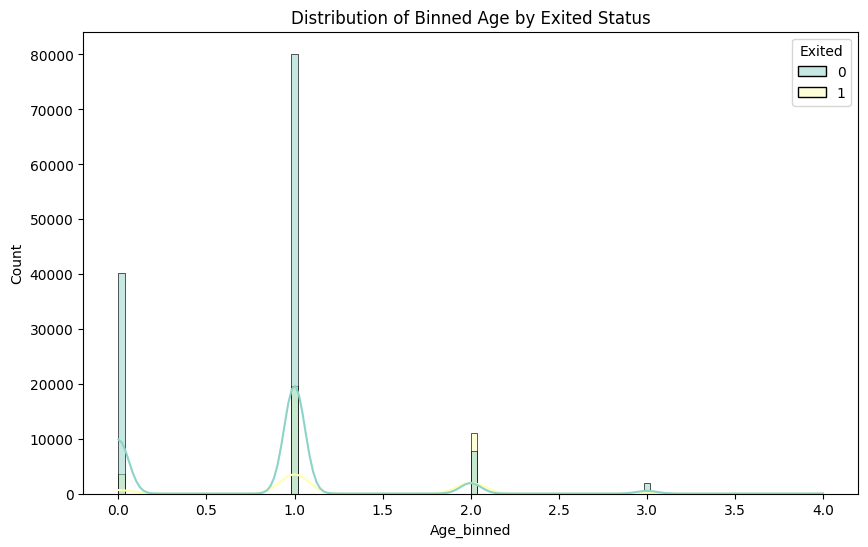

In [39]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
import phik

# 1. Create interaction term between HasCrCard and IsActiveMember
train_df['HasCrCard_IsActive'] = train_df['HasCrCard'] * train_df['IsActiveMember']

# 2. Binning continuous features (EstimatedSalary and Age)
train_df['EstimatedSalary_binned'] = pd.qcut(train_df['EstimatedSalary'], q=4, labels=False)
train_df['Age_binned'] = pd.cut(train_df['Age'], bins=5, labels=False)

# 3. Handle categorical columns (binary) by ensuring they are numeric
train_df['HasCrCard'] = train_df['HasCrCard'].astype(int)
train_df['IsActiveMember'] = train_df['IsActiveMember'].astype(int)

# 4. Target encoding for categorical variables
train_df['HasCrCard_encoded'] = train_df.groupby('HasCrCard')['Exited'].transform('mean')
train_df['IsActiveMember_encoded'] = train_df.groupby('IsActiveMember')['Exited'].transform('mean')

# 5. Scale the continuous features
scaler = StandardScaler()
train_df['Balance_scaled'] = scaler.fit_transform(train_df[['Balance']])

# 6. Perform Chi-Squared test for categorical features
X = train_df[['HasCrCard', 'IsActiveMember', 'HasCrCard_IsActive']]
y = train_df['Exited']
chi_scores, p_values = chi2(X, y)

# 7. Display Chi-Squared test results
chi2_results = pd.DataFrame({
    'Feature': ['HasCrCard', 'IsActiveMember', 'HasCrCard_IsActive'],
    'Chi-Squared Score': chi_scores,
    'P-Value': p_values
})
print("Chi-Squared Test Results:")
print(chi2_results)

# 8. Calculate Phi-K correlation matrix (suitable for categorical and numerical data)
columns = ['HasCrCard', 'IsActiveMember', 'HasCrCard_IsActive', 'EstimatedSalary_binned', 'Age_binned', 'Exited']
phik_corr_matrix = train_df[columns].phik_matrix()
print("\nPhi-K Correlation Matrix:")
print(phik_corr_matrix)

# 9. Visualize the distribution of the interaction feature
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='HasCrCard_IsActive', hue='Exited', kde=True, palette="Set2")
plt.title('Distribution of HasCrCard x IsActiveMember Interaction by Exited Status')
plt.show()

# 10. Visualize the binned features
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='EstimatedSalary_binned', hue='Exited', kde=True, palette="Set1")
plt.title('Distribution of Binned EstimatedSalary by Exited Status')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age_binned', hue='Exited', kde=True, palette="Set3")
plt.title('Distribution of Binned Age by Exited Status')
plt.show()


In [31]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import roc_auc_score, accuracy_score
# from sklearn.preprocessing import PolynomialFeatures

# # Load the datasets
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# # Define your feature columns and the target
# X = train_df.drop(columns=['Exited'])
# y = train_df['Exited']

# # Specify categorical and numerical columns
# categorical_features = ['Geography', 'Gender']
# numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# # Create a preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(), categorical_features)
#     ]
# )

# # Create the pipeline with preprocessing and a more powerful model (RandomForestClassifier)
# model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define parameter grid for hyperparameter tuning
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__class_weight': ['balanced', None]
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best estimator from grid search
# best_model = grid_search.best_estimator_

# # Predictions and scoring
# y_pred = best_model.predict(X_test)
# y_score = best_model.predict_proba(X_test)[:, 1]

# roc_auc = roc_auc_score(y_test, y_score)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'ROC AUC: {roc_auc}')
# print(f'Accuracy: {accuracy}')

# # Extract feature importances
# feature_importance = best_model.named_steps['classifier'].feature_importances_

# # Get feature names after preprocessing
# num_feature_names = numerical_features
# cat_feature_names = best_model.named_steps['preprocessor'].transformers[1][1].get_feature_names_out(categorical_features)
# all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# # Create a DataFrame for feature importance
# feature_importance_df = pd.DataFrame({
#     'Feature': all_feature_names,
#     'Importance': feature_importance
# }).sort_values(by='Importance', ascending=False)

# # Visualize feature importance
# plt.figure(figsize=(12, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.title('Feature Importance from Random Forest Classifier')
# plt.gca().invert_yaxis()  # To display the highest importance at the top
# plt.show()


In [32]:
# # Ensure the necessary libraries are imported
# import pandas as pd

# # Load the test dataset (ensure the path is correct)
# test_df = pd.read_csv('/mnt/data/test.csv')

# # Select the features based on the training dataset
# X_test = test_df[X.columns]

# # Use the fitted model to predict probabilities on the test set
# test_pred = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# # Assign the predictions to the test dataframe
# test_df['Exited'] = test_pred

# # Create the submission file
# test_df[['id', 'Exited']].to_csv('submission1.csv', index=False)

# print("Submission file created successfully!")


In [ ]:
import pandas as pd
import phik
from phik import resources as phik_resources
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency

# Additional libraries for WoE, IV calculation
import pandas as pd
import numpy as np

# Helper function to calculate WoE and IV
def calc_woe_iv(data, target, bins=10):
    woe_dict = {}
    iv_dict = {}
    for col in data.columns:
        temp = pd.crosstab(data[col], target)
        temp['Total'] = temp[0] + temp[1]
        temp['Dist Good'] = temp[0] / temp[0].sum()
        temp['Dist Bad'] = temp[1] / temp[1].sum()
        temp['WoE'] = np.log(temp['Dist Bad'] / temp['Dist Good'])
        temp['IV'] = (temp['Dist Bad'] - temp['Dist Good']) * temp['WoE']
        woe_dict[col] = temp['WoE'].to_dict()
        iv_dict[col] = temp['IV'].sum()
    return woe_dict, iv_dict

# Step 1: Load train and test datasets
train_df = pd.read_csv('train.csv')  # Adjust path if necessary
test_df = pd.read_csv('test.csv')  # Adjust path if necessary

# Step 2: Select numerical columns from the train dataset and target variable
X_train = train_df.select_dtypes(include=['number']).drop('Exited', axis=1)
y_train = train_df['Exited']

# Step 3: Select numerical columns from the test dataset
X_test = test_df.select_dtypes(include=['number'])  # Assumes no 'Exited' column in the test set

# Step 4: Feature Engineering - PhiK and MI Testing
# PhiK correlation testing for train data
phik_matrix = X_train.phik_matrix(interval_cols=X_train.columns.tolist())
phik_target_corr = phik_matrix['Exited'].sort_values(ascending=False)
print("Top features based on PhiK correlation:", phik_target_corr.head())

# Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)
mi_scores_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
print("Top features based on MI:", mi_scores_series.head())

# Step 5: WoE and IV Calculation
woe_dict, iv_dict = calc_woe_iv(X_train, y_train)
print("IV Scores for features:", iv_dict)

# Step 6: Feature Selection - Drop low IV features (optional threshold)
iv_threshold = 0.02  # Drop features with IV < 0.02
selected_features = [col for col, iv in iv_dict.items() if iv > iv_threshold]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 7: Add Polynomial Features (degree=2) to both train and test sets
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# Step 8: Standardize both the train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Step 9: Dimensionality Reduction using PCA
n_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 65)  # Use 65 as an upper limit
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Step 10: Create an Ensemble of Models with Logistic Regression
# Stack Logistic Regression, RidgeClassifier, and RandomForestClassifier
base_models = [
    ('ridge', RidgeClassifier()),
    ('lasso', Lasso(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=1000))

# Step 11: Hyperparameter Tuning using GridSearchCV for the ensemble model
param_grid = {
    'final_estimator__C': [0.1, 1, 10, 100],  # Regularization strength for logistic regression
    'final_estimator__solver': ['lbfgs'],
    'final_estimator__max_iter': [1000]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(stacking_clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

# Best ensemble model after cross-validation
best_model = grid_search.best_estimator_

# Step 12: Evaluate model on the training set
y_train_pred = best_model.predict(X_train_reduced)
y_train_pred_proba = best_model.predict_proba(X_train_reduced)[:, 1]

accuracy_train = accuracy_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Training Accuracy: {accuracy_train:.4f}')
print(f'Training ROC-AUC: {roc_auc_train:.4f}')

# Step 13: Make predictions on the test set
test_pred = best_model.predict_proba(X_test_reduced)[:, 1]  # Probability of exiting (class 1)

# Step 14: Save the predictions in the test DataFrame
test_df['Exited'] = test_pred

# Ensure correct column names are used for output (replace 'CustomerId' with the actual identifier)
if 'CustomerId' in test_df.columns:
    test_df[['CustomerId', 'Exited']].to_csv('submission4.csv', index=False)
else:
    print("Error: 'CustomerId' column not found in test data. Adjust the identifier column name.")
    test_df.to_csv('submission4.csv', index=False)  # Save the entire test DataFrame if 'CustomerId' not found

print("Submission file saved as 'submission4.csv'.")
